In [1]:
# imports and utility functions
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import epsilon_0 as eps_0, mu_0, pi
from scipy.special import erfc

from utils import load_tissue_diel_properties
from utils import register_sqrt_scale

# bhte constants for dry skin from https://itis.swiss/virtual-population/tissue-properties/database/
k = 0.37
rho = 1109.
C = 3391.
m_b = 1.8e-6

# Thermal response of human skin to microwave energy: A critical review

**Authors.** Kenneth R. Foster, Marvin C. Ziskin and Quirino Balzano

**Journal.** Health Phys. 111(6): 528-541; 2016

**DOI.** 10.1097/HP.0000000000000571

**Aim.** Review and modelling study of heating of tissue by microwave energy in the frequency range from 3 GHz through millimiter frequency range, up to 300 GHz motivated by the anticipated 5G communication technology deployment and its poorly researched potential hazard mechanisms. 

**Method.** Comprehensive survey of the available data on heating tissues with microwave energy in the millimeter-wave frequency spectrum; developement of a simple thermal model based on the Pennes' bioheat transfer equation without *post hoc* parameter adjustment; comparisson of existing data with model predictions.

**Results.** The simple model presented and solved both analytically and numerically (in 1-D and 2-D) presents successful approximation of thermal responses of tissue over a wide range of exposure conditions and is well-aligned with the available experimental data. However, one must be aware of assumptions made while developing this model: only the small irradiated area is considered so that the thermal conduction effects, which are essentially independent of physiological changes, e.g., thermoregulatory responses by means of blood perfusion gradient, predominated; exposure scenarios were of short duration so that the steady state was not reached, which further increase the relative importance of heat conduction and blood perfusion influence interplay; finally, the incident power densities were rather high, above rates of convective and radiative skin cooling, so that insulated boundary conditions did make a good approximation.

**Conclusion.** There is a great lack of data in the relevant literature on heating of human tissues, assuming it is the only detrimental effect on human tissue, by radio-frequency energy in the frequency range considered in the present study. The over-simplified one-dimensional thermal model strikes with surprisingly successful and acurate predictions of the thermal response in human tissue with no adjustment of model parameters, the problem is however, there are only few data to conduct tests on. The study has shown that the scaling properties of the Pennes' bioheat transfer equation and heat conduction equations can be useful in synthesizing thermal response of skin to radio-frequency exposures over wide ranges, and as such, this approach may be suitable for evaluation of safety limits for radiofrequency radiation and/or may be used as a analytical benchmark for more detailed numerical models.

---

**Model.** Pennes' bioheat transfer equation (BHTE) can be written as follows:

$$
k \nabla^2 T - \rho^2 C m_b T + \rho \mbox{SAR} = \rho C \frac{\partial T}{\partial t}
$$

where
- $T$ $[\mbox{°C}]$ is the temperature raise of the tissue above the baseline temperature (i.e., the temperature preceeding to radio-frequency exposure);
- $k$ $[\mbox{W/m°/C}]$ is the thermal conductivity of the tissue;
- $\mbox{SAR}$ $[\mbox{W/kg}]$ is the microwave power deposition rate;
- $C$ $[\mbox{Ws/kg/°C}]$ is the heat capacity of the tissue;
- $\rho$ $[\mbox{kg/m}^3]$ is the tissue density;
- $m_b$ $[\mbox{m}^3\mbox{s/kg}]$ is the volumetric perfusion rate of blood, which should be interpreted as an empirical parameter and not literally as a capillary perfusion rate

with insulated boundary conditions as a conservative assumption.
The choice of boundary conditions is justified because the rate of conduction of heat from microwave exposure into deeper layers of skin can be expected to be well below the rate of heat loss from skin to the environment:

$$
k \frac{\partial T}{\partial z} > h(\Delta T_{sur} - T_{air})
$$

where
- $T_{sur}$ $[\mbox{°C}]$ and $T_{air}$ $[\mbox{°C}]$ are the temperatures of the tissue surface and surrounding air;
- $\partial T / \partial z$ is the temperature gradient at the surface;
- $h$ $[\mbox{W/m/°C}]$ is the heat transfer coefficient (of the order $[1-10] \mbox{ W/m/°C}$).

Under the assumption of plane wave radio-frequency energy on a uniform plane of tissue with normal incidence, the source term in BHTE can be written as follows:

$$
\mbox{SAR} = \frac{I_0 T_{tr}}{\rho L} e^{-z/L}
$$

where
- $I_0$ $[\mbox{W/m^2}]$ is the incident power density on the tissue;
- $T_{tr}$ is the energy transmission coefficient into the tissue;
- $L$ $[\mbox{m}]$ is the energy penetration depth into tissue, which is defined as the distance beneath the surface at which the $\mbox{SAR}$ has fallen to a factor of $1/e$ below that at the surface ($z$-direction).

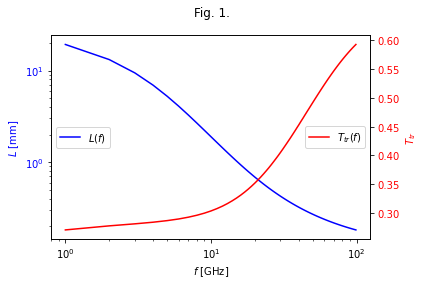

In [2]:
# frequency range 1 GHz up to 100 GHz
f = np.arange(1., 100.) * 1e9

# conductivity, relative permitivity, tangent loss and penetration depth (Gabriel et al. 1996)
sigma, eps_r, tan_loss, pen_depth = np.vectorize(load_tissue_diel_properties)('skin_dry', f)

# `pen_depth` is the energy penetration depth into tissue, which is defined as the distance 
# beneath the surface at which the SAR has fallen to a factor of 1/e below that at the surface;
# one-half of the more commonly reported wave penetration depth
pen_depth = pen_depth / 2

# air (vacuum) resistance 
Z_air = np.sqrt(mu_0 / eps_0)

# dry skin resistance
Z_skin_dry = np.sqrt(mu_0 / (eps_r * eps_0))

# energy (Fresnel) transmission coefficient into the tissue
T_tr = 2 * Z_skin_dry / (Z_air + Z_skin_dry)

# Fig. 1. in the paper - penetration depth and transmission coefficient over range of frequencies
fig, ax1 = plt.subplots()
fig.suptitle('Fig. 1.')
ax1.plot(f / 1e9, pen_depth * 10 * 100, 'b-', label='$L(f)$')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('$f$ [GHz]')
ax1.set_ylabel('$L$ [mm]', color='b')
ax1.legend(loc='center left')
ax2 = ax1.twinx()
ax2.plot(f / 1e9, np.abs(T_tr), 'r-', label='$T_{tr}(f)$')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_xscale('log')
ax2.set_ylabel('$T_{tr}$', color='r')
ax2.legend(loc='center right')
plt.tight_layout()
plt.show()

**Scaling properties of a 1-D version of the presented model: semi-infinite plane exposed to incident plane wave.** The thermal response of the 1-D model is characterized by two time scales representing heat transport by blood perfusion and thermal conduction, respectively:

$$
\tau_1 = \frac{1}{m_b \rho}; \qquad \tau_2 = \frac{L^2}{\alpha}
$$

where $\alpha = k / \rho C$ is the thermal diffusivity.

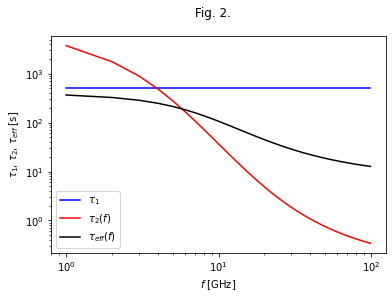

In [3]:
# intrinsic time scale of the BHTE representing heat transport by blood perfusion
tau_1 = 1 / (m_b * rho)

# intrinsic time scale of the BHTE representing heat transport by thermal conduction
tau_2 = pen_depth**2 * rho * C / k

# effective time scale of the BHTE
tau_eff = (tau_2 - np.sqrt(tau_1 * tau_2)) / (tau_2 / tau_1 - 1)

# Fig. 2. in the paper - time scales over range of frequencies
fig, ax = plt.subplots()
fig.suptitle('Fig. 2.')
ax.plot(f / 1e9, np.ones_like(f) * tau_1, 'b-', label='$\\tau_1$')
ax.plot(f / 1e9, tau_2, 'r-', label='$\\tau_2(f)$')
ax.plot(f / 1e9, tau_eff, 'k-', label='$\\tau_{eff}(f)$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$f$ [GHz]')
ax.set_ylabel('$\\tau_1$, $\\tau_2$, $\\tau_{eff}$ [s]')
ax.legend()
plt.show()

For low perfusion rates ($m_b \rightarrow 0$), BHTE approaches the simple heat conduction equation.
In that case, the transient solution for the surface temperature $T_{sur}$ is readily available, assuming $L \rightarrow 0$:

$$
T_{sur}(t) = C_1 \sqrt{t} - C_2 \big( 1 - e^{t/\tau_2} erfc \sqrt{t/\tau_2} \big)
$$

where
* $C_1 = \frac{2 I_0 T_{tr}}{\sqrt{\pi k \rho C}} = 9.54 \cdot 10^{-4} I_0 T_{tr} \mbox{ °C/s}^{0.5}$
* $C_2 = \frac{I_0 T_{tr} L}{k} = 2.7 \cdot I_0 T_{tr} \mbox{ °C}$

The term $C_2$ rapidly approaches zero as $t>\tau_2$ and describes an early transient effect associated with diffusion of heat over the energy penetration depth.
In the absence of a perfusion term, after an initial transient, $T_{sur}$ increases without limit with $t^{0.5}$.

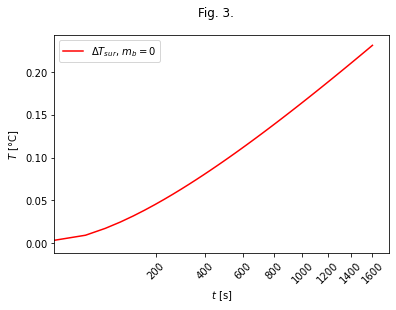

In [4]:
# frequency
f = 6e9

# conductivity, relative permitivity, tangent loss and penetration depth (Gabriel et al. 1996)
sigma, eps_r, tan_loss, pen_depth = load_tissue_diel_properties('skin_dry', f)

# air (vacuum) resistance 
Z_air = np.sqrt(mu_0 / eps_0)

# dry skin resistance
Z_skin_dry = np.sqrt(mu_0 / (eps_r * eps_0))

# energy (Fresnel) transmission coefficient into the tissue
T_tr = 2 * Z_skin_dry / (Z_air + Z_skin_dry)

# I_0 T_Tr = 10 W/m^2 at 6 GHz for a given "conduction-only" model
I_0 = 10 / T_tr

# intrinsic time scale of the BHTE representing heat transport by thermal conduction
tau_2 = pen_depth**2 * rho * C / k

# exposure time in seconds
t = np.linspace(0, 1600)

# closed-form solution of the 1-D BHTE with no blood perfusion considered;
# appropriate approximation for either short-term exposure or small exposure areas
C_1 = 2 * I_0 * T_tr / np.sqrt(pi * k * rho * C)
C_2 = I_0 * T_tr * pen_depth / k
T_sur = C_1 * np.sqrt(t) - C_2 * (1 - np.exp(t / tau_2) * erfc(np.sqrt(t / tau_2)))

# Fig. 3. in the paper - temperature raise in time (x-axis is square-root scaled)
fig, ax = plt.subplots()
fig.suptitle('Fig. 3.')
ax.plot(t, T_sur, 'r', label=f'$\\Delta T_{{sur}}$, $m_b = 0$')
register_sqrt_scale()
ax.set_xscale('sqrt')
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel('$t$ [s]')
ax.set_ylabel('$T$ [°C]')
ax.legend()
plt.show()

In the presence of blood flow, where $m_b > 0$, there is no known closed-form analytic solution in time.
However, as $T_{sur}$ approaches a steady state value $T_{ss}$ may be written as the product of the $\mbox{SAR}$ at the surface and an effective thermal time constant $\tau_{eff}$, as follows:

$$
T_{ss} = \frac{\mbox{SAR}_0}{C} \tau_{eff}
$$

where $\tau_{eff} = \frac{\tau_2 - \sqrt{\tau_1 \tau_2}}{\tau_2 / \tau_1 - 1}$ and $\mbox{SAR}_0 = \frac{I_0 T_{tr}}{\rho L}$.

In the limiting cases there $\tau_2 >> \tau_1$ and $\tau_2 << \tau_1$, $\tau_{eff}$ approaches the asymptotic values of $\tau_1$ and $(\tau_1 \tau_2)^{0.5}$, respectively, and $T_{ss}$ takes on the limiting values:

$$
T_{ss} \rightarrow \frac{I_0 T_{tr}}{\rho \sqrt{C m_b k}}, \quad \tau_1 / \tau_2 \rightarrow \infty
$$

$$
T_{ss} \rightarrow \frac{I_0 T_{tr}}{L C m_b \rho^2}, \quad \tau_1 / \tau_2 \rightarrow 0
$$

For the mmWave frequency range, of interest in this paper, $\tau_1 >> \tau_2$, and the steady state increase in temperature at the surface for the 1-D case is best described above for the associated case, showing a modest dependence on the blood perfusion term.

The scaling properties of the BHTE in the spatial domain can be investigated with reference to the Green's function, where the Green's function decays exponentially with distance with two intrinsic distance scales,
* the one that accounts for the smoothing effect of blood perfusion, and

$$
R_1 = \frac{\sqrt{k}}{\rho \sqrt{m_b c}}
$$

* the one that represents a measure of the distance that heat diffuses in time, $t$,

$$
R_2 = \sqrt{4 \alpha t} \sim 0.5 \sqrt{t} \mbox{ mm s}^{-0.5}
$$

# Thermal modelling for the next generation of radiofrequency exposure limits: Commentary

**Authors.** Kenneth R. Foster, Marvin C. Ziskin and Quirino Balzano

**Journal.** Health Phys. 113(1): 41-53; 2017

**DOI.** 10.1097/HP.0000000000000671

**Aim.** Review/commentary/analysis of the current* guideliness. The overall goal is to evaluate two sets of guidelines for human exposure to radiofrequency energy, focusing on the frequency range above the transition frequency at 3 - 10 GHz where the reviewed guidelines change their basic restrictions from specific absorption rate to incident power densitiy, throughout the mmWave range up to 300 GHz. Important caveat is that the authors consider exclusively reported thermal effects as potential hazards to human tissue and do not comment on the contentious issue of non-thermal effects, which are scientifically poorly supported.

**Method.** The analysis is based on a simple thermal model based on Pennes' bioheat transfer equation (BHTE) assuming purely surface heating, which is an excellent approximation for millimeter waves (30 - 300 GHz) but overestimetas temperature increase at lower frequencies. The subject to heating is an adiabatic half plane of tissue, where it is assumed that no heat in the skin is lost to the surrounding environment.

**Results.** Surface heating approximation is excellent for mmWave range, where the energy penetration depth is < 1mm but, as expected, fails progressively at lower frequences. The conduction-only model can be well approximation to the BHTE for small irradiated areas or for short times in the step response; for longer exposure times and larger exposed areas it will fail progressively. The simple model could be used for relatively specific scenarios and as a benchmark for more complex and realistic numerical simulations. Based on the model and the current* guidelines, authors infere number of recommendations and provide an in-depth discussion on the subject of basic restrictions and reference levels for radiofrequency exposure.

**Conclusion.** Overall conclusion is that there exists lack of consistency in guidelines regarding averaging times and averaging area, which are not consistent with scaling characteristics of the BHTE. Further more, reviewed guidelines* are highly conservative relative to ther stated goals of limiting temperature in tissue.

(*) by "current" and "reviewed" guidelines, it is reffered to the International Commision of Nonionizing Radiation Protection (ICNIRP 1998) and the Institute of Electrical and Electronics Engineers (IEEE 2005) guidelines, both revised and updated as of 11-Feb-21. 

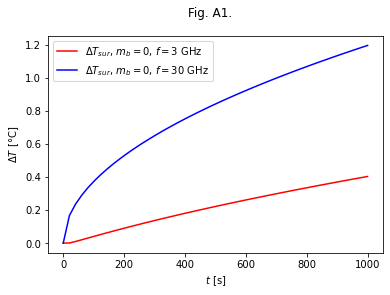

In [5]:
# incident power density
I_0 = 100

# frequencies
f = np.array([3, 30]) * 1e9

# conductivity, relative permitivity, tangent loss and penetration depth (Gabriel et al. 1996)
sigma, eps_r, tan_loss, pen_depth = np.vectorize(load_tissue_diel_properties)('skin_dry', f)

# `pen_depth` is the energy penetration depth into tissue, which is defined as the distance 
# beneath the surface at which the SAR has fallen to a factor of 1/e below that at the surface;
# one-half of the more commonly reported wave penetration depth
pen_depth = pen_depth / 2

# air (vacuum) resistance 
Z_air = np.sqrt(mu_0 / eps_0)

# dry skin resistance
Z_skin_dry = np.sqrt(mu_0 / (eps_r * eps_0))

# energy (Fresnel) transmission coefficient into the tissue
T_tr = 2 * Z_skin_dry / (Z_air + Z_skin_dry)

# closed-form solution for uniformly irradiated plane, no blood perfusion (m_b = 0),
# and finite energy penetration depth (pen_depth > 0)
C_1 = 2 * I_0 * T_tr / np.sqrt(pi * k * rho * C)
C_2 = I_0 * T_tr * pen_depth / k
t = np.linspace(0, 1000)
_t = np.column_stack((t, t))
T_sur = C_1 * np.sqrt(_t) - C_2 * (1 - np.exp(_t / tau_2) * erfc(np.sqrt(_t / tau_2)))

# Fig. A1. in the paper - temperature raise in time
fig, ax = plt.subplots()
fig.suptitle('Fig. A1.')
ax.plot(t, T_sur[:, 0], 'r', label=f'$\\Delta T_{{sur}}$, $m_b = 0$, $f = 3$ GHz')
ax.plot(t, T_sur[:, 1], 'b', label=f'$\\Delta T_{{sur}}$, $m_b = 0$, $f = 30$ GHz')
ax.set_xlabel('$t$ [s]')
ax.set_ylabel('$\\Delta T$ [°C]')
ax.legend()
plt.show()

In [6]:
# incident power density
I_0 = 100

# frequencies
f = np.array([3, 10, 30, 100]) * 1e9

# conductivity, relative permitivity, tangent loss and penetration depth (Gabriel et al. 1996)
sigma, eps_r, tan_loss, pen_depth = np.vectorize(load_tissue_diel_properties)('skin_dry', f)

# `pen_depth` is the energy penetration depth into tissue, which is defined as the distance 
# beneath the surface at which the SAR has fallen to a factor of 1/e below that at the surface;
# one-half of the more commonly reported wave penetration depth
pen_depth = pen_depth / 2

# air (vacuum) resistance 
Z_air = np.sqrt(mu_0 / eps_0)

# dry skin resistance
Z_skin_dry = np.sqrt(mu_0 / (eps_r * eps_0))

# energy (Fresnel) transmission coefficient into the tissue
T_tr = 2 * Z_skin_dry / (Z_air + Z_skin_dry)

# closed-form solution for uniformly irradiated plane, surface heating (pen_depth = 0), finite blood perfusion (m_b > 0)
# frequency independent scenario because of the purely surface heating
R_1 = np.sqrt(k) / (rho * np.sqrt(m_b * C))
T_sur_ss = I_0 * T_tr * R_1 / k

# (relevant parts of the) Table A1.
print('f [GHz] \t L [mm] \t T_tr \t\t T_sur [°C]')
for _f, _pen_depth, _T_tr, _T_sur_ss in zip(f, pen_depth, T_tr, T_sur_ss):
    print(f'{_f / 1e9} \t\t {round(_pen_depth * 1000, 2)} \t\t {round(_T_tr, 2)} \t\t {round(_T_sur_ss, 2)}')

f [GHz] 	 L [mm] 	 T_tr 		 T_sur [°C]
3.0 		 9.42 		 0.28 		 0.53
10.0 		 1.9 		 0.3 		 0.58
30.0 		 0.43 		 0.4 		 0.77
100.0 		 0.18 		 0.59 		 1.13


# Modelling tissue heating from exposure to radiofrequency energy and relevance of tissue heating to exposure limits: Heating factor

**Authors.** Kenneth R. Foster, Marvin C. Ziskin, Quirino Balzano and Giorgi Bit-Babik

**Journal.** Health Phys. 115(2): 295-307; 2018

**DOI.** 10.1097/HP.0000000000000854

**Aim.**

**Method.**

**Results.**

**Conclusion.**